In [7]:
import os 
os.listdir('../')
# train and test images are in differant folders (not included in the github repo )
# i put them in the upper folder containing them

['bamboo-project2', 'license_plates_detection_train', 'test_private']

In [3]:
import pandas as pd 

In [4]:
df = pd.read_csv("./license_plates_detection_train.csv")

In [5]:
df.head()

,img_id,ymin,xmin,ymax,xmax
0,1.jpg,276,94,326,169
1,10.jpg,311,395,344,444
2,100.jpg,406,263,450,434
3,101.jpg,283,363,315,494
4,102.jpg,139,42,280,222


In [10]:
l = df.loc[0,:]
l

img_id    1.jpg
ymin        276
xmin         94
ymax        326
xmax        169
Name: 0, dtype: object

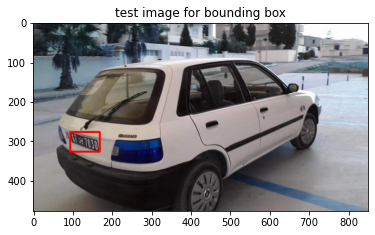

In [13]:
import cv2 
import matplotlib.pyplot as plt 
img = cv2.imread("../license_plates_detection_train/1.jpg")
cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
plt.imshow(img)
plt.title("test image for bounding box")
plt.show()

In [14]:
def show_bb(line_from_df):
    l = df.iloc[line_from_df,:]
    #change this if the train and test folder are somewhere else
    img = cv2.imread("../license_plates_detection_train/"+l[0])
    cv2.rectangle(img,(l[2],l[1]),(l[4],l[3]),(255,0,0),3)
    plt.imshow(img)
    plt.title("test image for bounding box")
    plt.show()

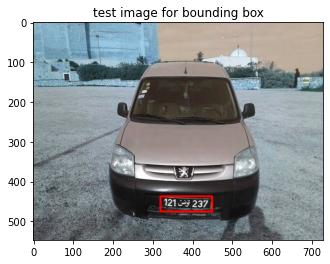

In [15]:
show_bb(5)